In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [11]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11bd49160>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [13]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11bd49cf8>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

Exploratory Climate Analysis

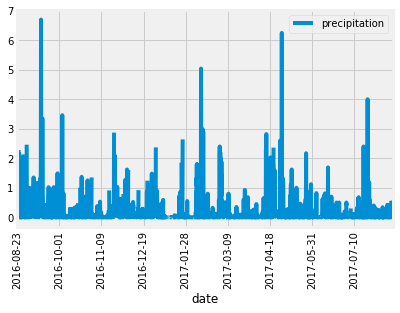

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#year_ago = dt.date.today() - dt.timedelta(days=365)

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter((Measurement.date) >= query_date).all()
    
#print("There was {} precipitaion over the last year".format(precipitation.prcp))

df = pd.DataFrame(precipitation, columns=["date","precipitation"])

df.set_index(["date"],inplace = True)
df = df.sort_index()
df

df.plot(rot=90)
# Calculate the date 1 year ago from the last data point in the database
#most_recent = session.query(func.max(Measurement.date)).all()
#print(most_recent)
                            
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [59]:
df.head(50)

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


NameError: name 'most_recent' is not defined